In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams.update({'font.size': 16})
from scipy.optimize import minimize
import ipywidgets as widgets
from ipywidgets import interact
import plotly.express as px
from datetime import datetime
from plotly import graph_objects as go

In [2]:
data1 = pd.read_csv('WHO-COVID-19-global-data.csv')
data2 = pd.read_csv('countries.csv',skiprows=1, on_bad_lines = 'skip', names=['Country_code','latitude','longitude','Country'])
data = pd.merge(data1, data2, on='Country_code', how='left')
#data["Cumulative_cases"].fillna("", inplace = True)
#data.dropna(subset=["New_cases"], inplace = True)
data

,Date_reported,Country_code,Country_x,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,latitude,longitude,Country_y
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0,33.939110,67.709953,Afghanistan
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0,33.939110,67.709953,Afghanistan
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0,33.939110,67.709953,Afghanistan
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0,33.939110,67.709953,Afghanistan
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0,33.939110,67.709953,Afghanistan
...,...,...,...,...,...,...,...,...,...,...,...
246949,2022-11-05,ZW,Zimbabwe,AFRO,0,257893,0,5606,-19.015438,29.154857,Zimbabwe
246950,2022-11-06,ZW,Zimbabwe,AFRO,0,257893,0,5606,-19.015438,29.154857,Zimbabwe
246951,2022-11-07,ZW,Zimbabwe,AFRO,0,257893,0,5606,-19.015438,29.154857,Zimbabwe
246952,2022-11-08,ZW,Zimbabwe,AFRO,0,257893,0,5606,-19.015438,29.154857,Zimbabwe


## Geographical plot comparing cases between countries on a specified date.

In [3]:
dates = data.Date_reported[data.New_cases > 0].unique()
@interact(
    date = widgets.SelectionSlider(
    options= pd.DatetimeIndex(dates),
    value= datetime.strptime('2020-02-24', '%Y-%m-%d'),
    description='Date',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)
)

def geoPlot(date):
    date = date.strftime('%Y-%m-%d')
    cases = data.New_cases[data.Date_reported == date]
    deaths = data.New_deaths[data.Date_reported == date]
    country = data.Country_x[data.Date_reported == date]
    latitude = data.latitude[data.Date_reported == date]
    longitude = data.longitude[data.Date_reported == date]
    fig = px.scatter_geo(
                    lat=latitude,
                    lon=longitude,
                     size= cases,
                     color= country, 
                    hover_data = {
                         'Country' : country,
                         'New Cases' : cases.astype(str) ,
                         'New Deaths' : deaths.astype(str),
                     },
                    title = "Global map of new Covid cases by date.",
                    hover_name = country,
                     )
    fig.update_geos(
        showcountries=True,
        showcoastlines=True,
        coastlinecolor="#AFDCEC",
        lakecolor="#00008B",
        showrivers=True,
        rivercolor="#8B0000"
    )
    fig.show()

interactive(children=(SelectionSlider(continuous_update=False, description='Date', options=(Timestamp('2020-02…

## Comparison of total cases and deaths by Country.

In [4]:
countries = data.Country_x.unique()
@interact(
    country1 = widgets.Select(
    options=countries,
    value='Afghanistan',
    description='Countries:',
    disabled=False
),
    
    country2 = widgets.Select(
    options=countries,
    value='Afghanistan',
    description='Countries:',
    disabled=False
)


)
def funnelPlot(country1, country2):
    c = data.groupby(['Country_x'])['Cumulative_cases'].max()
    d = data.groupby(['Country_x'])['Cumulative_deaths'].max()
    c1Cases = c[country1]
    c1Deaths = d[country1]
    c2Cases = c[country2]
    c2Deaths = d[country2]
    fun = go.Figure()
    fun.add_trace(go.Funnel(
    name = country1,
    y = ["Cumulative Cases", "Cumulative Deaths"],
    x = [(c1Cases/c1Cases)/30, c1Deaths/c1Cases],
    textinfo = "value",
    ))
    
    fun.add_trace(go.Funnel(
    name = country2,
    y = ["Cumulative Cases", "Cumulative Deaths"],
    x = [(c2Cases/c2Cases)/30, c2Deaths/c2Cases],
    textinfo = "value",
    ))

    fun.show()


interactive(children=(Select(description='Countries:', options=('Afghanistan', 'Albania', 'Algeria', 'American…

Funnel plot is used for comparing sets of data. It's not as nice and intricate to look at as other plots, and doesn't really tell you that much at a glance. The plot itself doesn't allow for much customization, and is vastly inferior to other plots that might be used for comparison between two sets of data.

## 3-D line plot of Brownian Motion

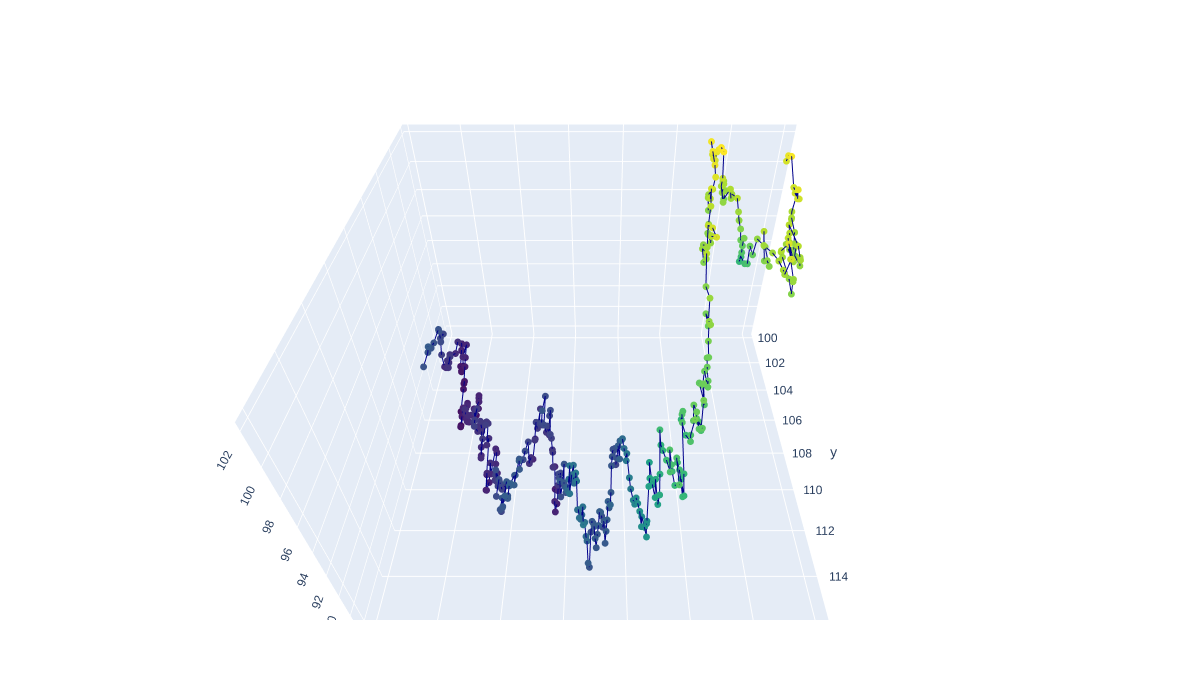

In [5]:
rs = np.random.RandomState()
rs.seed(0)

def brownian_motion(T = 1, N = 100, mu = 0.1, sigma = 0.01, S0 = 20):
    dt = float(T)/N
    t = np.linspace(0, T, N)
    W = rs.standard_normal(size = N)
    W = np.cumsum(W)*np.sqrt(dt) # standard brownian motion
    X = (mu-0.5*sigma**2)*t + sigma*W
    S = S0*np.exp(X) # geometric brownian motion
    return S

dates = pd.date_range('2012-01-01', '2013-02-22')
T = (dates.max()-dates.min()).days / 365
N = dates.size
start_price = 100
y = brownian_motion(T, N, sigma=0.1, S0=start_price)
z = brownian_motion(T, N, sigma=0.1, S0=start_price)

fig = go.Figure(data=go.Scatter3d(
    x=dates, y=y, z=z,
    marker=dict(
        size=4,
        color=z,
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
))

fig.update_layout(
    width=800,
    height=700,
    autosize=False,
    scene=dict(
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=0,
                y=1.0707,
                z=1,
            )
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'
    ),
)

fig.show()

Brownian motion is the erratic movement of microsopic particles in a fluid, as a result of the surrounding molecules.